# Unit 5 - Financial Planning

In [117]:
# Initial imports
%config Completer.use_jedi = False
import os
from pathlib import Path
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import datetime as dt
import pytz

%matplotlib inline

In [118]:
# Load .env enviroment variables
api_key = Path(r'../env.env')
load_dotenv(api_key)

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [119]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [120]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [121]:
# Fetch current BTC price

btc_raw_data = requests.get(btc_url)
btc_raw_data.content
btc_data = btc_raw_data.json()
btc_price = btc_data['data']['1']['quotes']['CAD']['price']

# Fetch current ETH price

eth_raw_data = requests.get(eth_url)
eth_raw_data.content
eth_data = eth_raw_data.json()
eth_price = eth_data['data']['1027']['quotes']['CAD']['price']


# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $34420.75
The current value of your 5.3 ETH is $11546.48


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [122]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [123]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [124]:
# Format current date as ISO format
today = pd.Timestamp('2022-09-07', tz='America/New_York').isoformat()


# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
df_portfolio = alpaca.get_bars(
    tickers,
    timeframe,
    start = today,
    end = today
).df
df_portfolio


# Reorganize the DataFrame
# Separate ticker data
AGG = df_portfolio[df_portfolio['symbol'] == "AGG"].drop(['symbol', 'trade_count', 'vwap'], axis=1)
SPY = df_portfolio[df_portfolio['symbol'] == "SPY"].drop(['symbol', 'trade_count', 'vwap'], axis=1)

# Concatenate the ticker DataFrames
df_portfolio = pd.concat([AGG, SPY], axis = 1, keys=['AGG', 'SPY'])

# Preview DataFrame
df_portfolio

AGG                                     SPY  \
                            open    high    low   close   volume    open   
timestamp                                                                  
2022-09-07 04:00:00+00:00  99.73  100.13  99.72  100.11  3602611  390.43   

                                                            
                             high    low   close    volume  
timestamp                                                   
2022-09-07 04:00:00+00:00  398.59  390.2  397.78  70572980

In [125]:
# Pick AGG and SPY close prices
agg_close_price = float(df_portfolio['AGG']['close'])
spy_close_price = float(df_portfolio['SPY']['close'])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $100.11
Current SPY closing price: $397.78


In [126]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $19889.00
The current value of your 200 AGG shares is $20022.00


### Savings Health Analysis

In [76]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
crypto = my_btc_value + my_eth_value
shares = my_spy_value + my_agg_value
    

# Create savings DataFrame
amount = ['crypto', 'shares']
savings = { 
    'amount' :  [ crypto , shares ] 
}
df_savings = pd.DataFrame(savings, index = amount)

# Display savings DataFrame
df_savings

,amount
crypto,45835.74744
shares,39911.00000


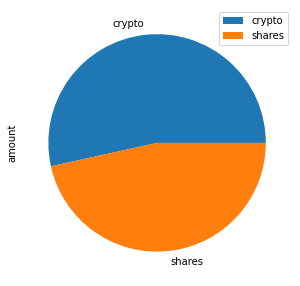

In [77]:
# Plot savings pie chart
plot = df_savings.plot.pie(y='amount', figsize = (5,5))

In [78]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = crypto + shares

# Validate saving health

if total_savings > emergency_fund:
    print('Congratulations, you have enough money in this fund!') 
elif total_savings == emergency_fund:
    print('Congratulations, you have reached your financial goal.')
elif total_savings < emergency_fund:
    print(f'You are $ { emergency_fund - total_savings} away from reaching the goal.')
    

Congratulations, you have enough money in this fund!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [79]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2017-08-07', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2022-08-07', tz='America/New_York').isoformat()

In [105]:
# Get 5 years' worth of historical data for SPY and AGG
df_stock_data = alpaca.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df
df_stock_data

# Reorganize the DataFrame
# Separate ticker data
SPY = df_stock_data[df_stock_data['symbol']=='SPY'].drop(['symbol','trade_count', 'vwap'], axis=1)
AGG = df_stock_data[df_stock_data['symbol']=='AGG'].drop(['symbol','trade_count', 'vwap'], axis=1)


# Concatenate the ticker DataFrames
df_stock_data = pd.concat([SPY, AGG],axis=1, keys=['SPY','AGG'] )

# Display sample data
df_stock_data.head()

SPY                                       \
                             open    high     low     close     volume   
timestamp                                                                
2017-08-07 04:00:00+00:00  247.49  247.87  247.37  247.8400   31995021   
2017-08-08 04:00:00+00:00  247.51  248.91  246.83  247.2700   61719353   
2017-08-09 04:00:00+00:00  246.47  247.31  246.06  247.2700   62632619   
2017-08-10 04:00:00+00:00  246.29  246.44  243.70  243.7599  120418270   
2017-08-11 04:00:00+00:00  244.02  244.80  243.75  244.1100   74869947   

                              AGG                                      
                             open    high       low    close   volume  
timestamp                                                              
2017-08-07 04:00:00+00:00  109.69  109.72  109.6066  109.685  2359826  
2017-08-08 04:00:00+00:00  109.67  109.69  109.5000  109.580  2570876  
2017-08-09 04:00:00+00:00  109.87  109.87  109.6600  109.670  2308932  
2017-08-10 04:00:00+00:00  109.70  109.85  109.6700  109.800  2004163  
2017-08-11 04:00:00+00:00  109.75  109.94  109.6800  109.870  1913253

In [106]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
mc_sim = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.6,0.4],
    num_simulation = 500,
    num_trading_days = 252*30
)


In [107]:
# Printing the simulation input data
mc_sim.portfolio_data.head()

SPY                                       \
                             open    high     low     close     volume   
timestamp                                                                
2017-08-07 04:00:00+00:00  247.49  247.87  247.37  247.8400   31995021   
2017-08-08 04:00:00+00:00  247.51  248.91  246.83  247.2700   61719353   
2017-08-09 04:00:00+00:00  246.47  247.31  246.06  247.2700   62632619   
2017-08-10 04:00:00+00:00  246.29  246.44  243.70  243.7599  120418270   
2017-08-11 04:00:00+00:00  244.02  244.80  243.75  244.1100   74869947   

                                           AGG                             \
                          daily_return    open    high       low    close   
timestamp                                                                   
2017-08-07 04:00:00+00:00          NaN  109.69  109.72  109.6066  109.685   
2017-08-08 04:00:00+00:00    -0.002300  109.67  109.69  109.5000  109.580   
2017-08-09 04:00:00+00:00     0.000000  109.87  109.87  109.6600  109.670   
2017-08-10 04:00:00+00:00    -0.014195  109.70  109.85  109.6700  109.800   
2017-08-11 04:00:00+00:00     0.001436  109.75  109.94  109.6800  109.870   

                                                 
                            volume daily_return  
timestamp                                        
2017-08-07 04:00:00+00:00  2359826          NaN  
2017-08-08 04:00:00+00:00  2570876    -0.000957  
2017-08-09 04:00:00+00:00  2308932     0.000821  
2017-08-10 04:00:00+00:00  2004163     0.001185  
2017-08-11 04:00:00+00:00  1913253     0.000638

In [108]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
mc_sim.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/saibalsaha/bootcamp_documents/BOOTCAMP/MY FILES/Assignments/ASSIGNMENT_5/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.008457,1.001471,0.997891,0.995079,1.003428,0.999602,0.993006,1.005281,0.996278,1.008019,...,0.987944,1.003856,0.991245,0.997354,0.995597,1.000195,1.009792,1.000418,1.004347,0.993869
2,1.015093,1.006897,1.007876,1.005581,1.009739,0.997340,1.009469,1.006686,0.992474,0.990948,...,0.979239,0.999651,0.986526,0.991086,0.999048,1.002651,1.016138,1.009204,0.998457,0.994000
3,1.016619,1.010965,1.023189,1.000805,1.011341,0.990580,1.007590,1.000229,0.983979,1.000445,...,0.985894,1.012077,0.966721,0.989210,1.008121,1.000452,1.002466,1.007775,1.009935,0.989620
4,1.011297,1.009978,1.005879,1.004973,1.017341,0.985702,1.011689,1.009410,0.983681,0.993825,...,0.986946,1.008792,0.960620,0.984094,1.003992,0.992106,1.019873,1.013322,1.008645,0.985859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,13.340605,5.649583,3.405893,1.297609,15.387613,2.457664,9.136219,5.119229,4.677086,9.964448,...,4.243949,3.596686,13.222685,5.709752,3.593099,7.112613,5.806219,8.652058,7.699775,3.001452
7557,13.275459,5.686156,3.408270,1.301421,15.411499,2.465792,9.115501,5.138818,4.655587,9.913744,...,4.299751,3.647321,13.276482,5.717827,3.641822,7.072996,5.879241,8.776827,7.706546,2.996905
7558,13.347131,5.766511,3.430888,1.285190,15.482406,2.488144,9.038062,5.162046,4.598561,9.792373,...,4.244526,3.624550,13.182276,5.655968,3.655293,7.056921,5.857742,8.678811,7.623425,3.006438
7559,13.130383,5.736328,3.409328,1.276140,15.426226,2.461255,9.103295,5.202516,4.569462,9.934391,...,4.278999,3.610455,13.058504,5.612027,3.663670,7.120336,5.909310,8.701332,7.664325,3.031312


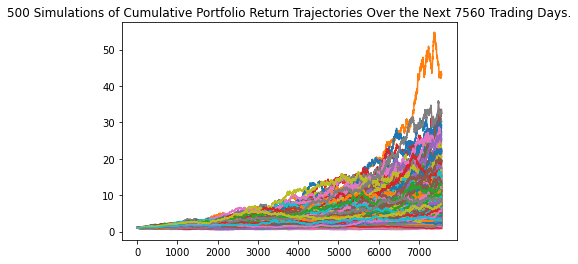

In [109]:
# Plot simulation outcomes
line_plot = mc_sim.plot_simulation()

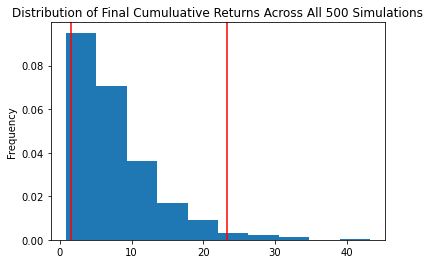

In [110]:
# Plot probability distribution and confidence intervals
dist_plot = mc_sim.plot_distribution()

### Retirement Analysis

In [114]:
# Fetch summary statistics from the Monte Carlo simulation results
port_stat = mc_sim.summarize_cumulative_return()

# Print summary statistics
print(port_stat)

count           500.000000
mean              7.941302
std               6.024448
min               0.819373
25%               3.728962
50%               5.956920
75%              10.370239
max              43.293471
95% CI Lower      1.486084
95% CI Upper     23.288078
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [115]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(port_stat[8]*initial_investment,2)
ci_upper = round(port_stat[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $29721.68 and $465761.56


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [116]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(port_stat[8]*initial_investment,2)
ci_upper = round(port_stat[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $44582.52 and $698642.35


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [129]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
mc_sim_five = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.6,0.4],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [154]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
mc_sim_five.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/saibalsaha/bootcamp_documents/BOOTCAMP/MY FILES/Assignments/ASSIGNMENT_5/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.005815,0.981521,0.999789,0.992332,1.001550,1.000035,0.994587,0.981072,0.997320,1.013657,...,1.006782,1.008178,0.985112,1.010471,1.014646,1.001736,0.996333,0.988324,1.005063,1.013914
2,1.013346,0.971833,0.999239,0.987292,0.995017,0.993463,0.993327,0.967672,1.004073,1.014584,...,1.012596,1.016260,0.986872,0.999643,1.009491,1.004420,1.006289,1.000170,1.004841,1.019270
3,1.016424,0.967401,0.988559,0.964952,0.997919,1.001383,0.990900,0.975985,0.989663,1.028441,...,1.022460,1.005703,0.988163,0.998981,0.998708,1.010117,1.010047,1.000362,0.995998,1.016078
4,1.014905,0.974426,0.978622,0.967304,0.991174,1.005810,0.994558,0.979331,0.998816,1.026325,...,1.018745,1.006032,1.005068,1.001878,0.996815,1.019530,1.005604,0.997891,0.998911,1.012618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.339899,1.112251,1.466205,1.088555,1.401992,1.110684,1.013343,1.543052,1.582682,1.149030,...,1.785871,1.246924,1.271473,1.533141,1.008293,1.302778,1.325438,1.852848,1.301397,1.169955
1257,1.331856,1.129858,1.454324,1.086622,1.413040,1.101170,1.010058,1.545634,1.584789,1.160835,...,1.806887,1.253243,1.262441,1.541728,1.012291,1.298352,1.336474,1.847411,1.299462,1.162863
1258,1.325348,1.125108,1.459006,1.089635,1.430870,1.105055,1.005868,1.552313,1.587278,1.154560,...,1.800500,1.230160,1.273418,1.534526,1.024212,1.305730,1.341324,1.854797,1.307394,1.151600
1259,1.331253,1.141123,1.473545,1.096001,1.441719,1.112310,1.005211,1.559235,1.583710,1.138365,...,1.809909,1.242563,1.272941,1.541441,1.019848,1.292213,1.348821,1.833993,1.326044,1.140887


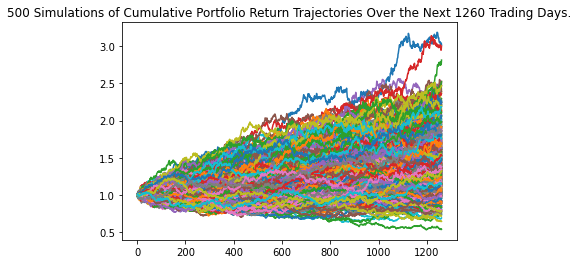

In [155]:
# Plot simulation outcomes
line_plot_five = mc_sim_five.plot_simulation()

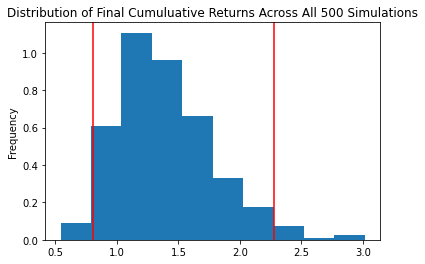

In [156]:
# Plot probability distribution and confidence intervals
dist_plot_five = mc_sim_five.plot_distribution()

In [158]:
# Fetch summary statistics from the Monte Carlo simulation results
port_stat_five = mc_sim_five.summarize_cumulative_return()

# Print summary statistics
print(port_stat_five)

count           500.000000
mean              1.396191
std               0.387003
min               0.541288
25%               1.128694
50%               1.331187
75%               1.613921
max               3.015303
95% CI Lower      0.801691
95% CI Upper      2.276959
Name: 1260, dtype: float64


In [160]:
# Set initial investment
initial_investment = 120000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(port_stat_five[8]*initial_investment,2)
ci_upper_five = round(port_stat_five[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $120000 in the portfolio over the next 5 years will end within in the range of $96202.93 and $273235.12


--We can see that even with increasing the initial investment by 6 fold and reducing the investment period bt 6 fold, the performance of the portfolio is significantly worse off than a smaller investment over 30 years.

### Ten Years Retirement Option

In [153]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
mc_sim_ten = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.6,0.4],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [161]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
mc_sim_ten.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/saibalsaha/bootcamp_documents/BOOTCAMP/MY FILES/Assignments/ASSIGNMENT_5/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998955,1.005961,1.013109,0.995539,0.999710,1.004388,1.005506,0.989106,0.998617,1.009954,...,0.998203,1.008594,1.013163,1.000123,1.002573,1.008358,1.021633,1.001150,1.004413,0.997578
2,1.010438,0.996470,1.017098,0.994147,0.994159,1.006196,0.997982,0.978737,0.994479,1.002287,...,0.990786,1.021274,1.011461,0.994235,1.008193,1.024100,1.034450,0.999529,1.013415,0.997066
3,1.011245,0.999608,1.024515,0.985137,0.994013,1.003270,1.004710,0.987816,0.993426,0.992779,...,1.000186,1.031463,1.009931,0.996108,1.017412,1.026060,1.023133,0.996050,1.021136,0.997669
4,1.004095,0.998513,1.034584,0.976196,0.985289,1.007245,1.013898,0.995747,0.994192,0.982356,...,0.997646,1.034957,1.005837,0.991637,1.015298,1.020707,1.021170,0.991021,1.025037,0.995402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.160241,1.856053,1.608704,1.776681,1.443501,3.937544,1.610385,1.546875,2.284498,1.281362,...,2.136088,1.627778,1.273961,1.090287,1.425100,2.098451,0.899936,1.710250,2.414677,1.528690
2517,2.160807,1.885377,1.634039,1.793606,1.444485,3.951295,1.602378,1.555040,2.288749,1.270419,...,2.120608,1.627789,1.262460,1.094398,1.412562,2.098940,0.900748,1.723989,2.374237,1.526839
2518,2.144141,1.897448,1.646181,1.791436,1.458698,3.953282,1.608673,1.565630,2.246850,1.258306,...,2.114723,1.625552,1.260553,1.074805,1.404137,2.086555,0.903201,1.739140,2.354807,1.537055
2519,2.150031,1.900656,1.652641,1.798615,1.475965,3.918510,1.601294,1.547416,2.253160,1.265723,...,2.124009,1.604360,1.261780,1.060783,1.407044,2.087401,0.893352,1.740849,2.356283,1.522273


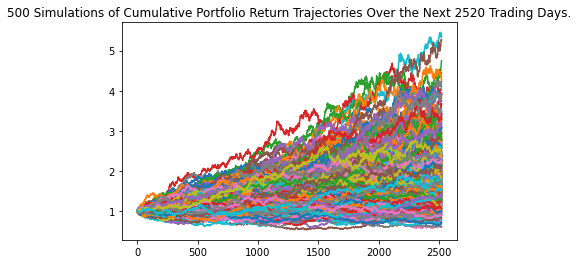

In [163]:
# Plot simulation outcomes
line_plot_ten = mc_sim_ten.plot_simulation()

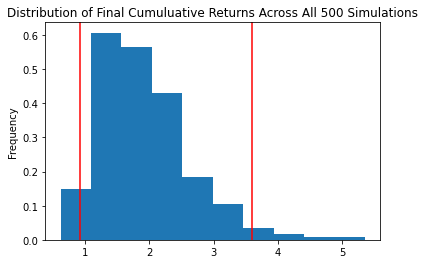

In [164]:
# Plot probability distribution and confidence intervals
dist_plot_ten = mc_sim_ten.plot_distribution()

In [165]:
# Fetch summary statistics from the Monte Carlo simulation results
port_stat_ten = mc_sim_ten.summarize_cumulative_return()

# Print summary statistics
print(port_stat_ten)

count           500.000000
mean              1.926603
std               0.715455
min               0.612989
25%               1.428860
50%               1.811407
75%               2.277287
max               5.358003
95% CI Lower      0.917573
95% CI Upper      3.592442
Name: 2520, dtype: float64


In [168]:
# Set initial investment
initial_investment = 80000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(port_stat_ten[8]*initial_investment,2)
ci_upper_ten = round(port_stat_ten[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $80000 in the portfolio over the next 10 years will end within in the range of $73405.83 and $287395.34


--We can see that even with increasing the initial investment by 4 fold and reducing the investment period bt 3 fold, the performance of the portfolio is still significantly worse off than a smaller investment over 30 years.